In [1]:
library(stats)
library(survival)
library(SurvRegCensCov)

The following table gives a small data set of survival times and a covariate $z$:


| patient ID | survival time in years | $\delta$ | z |
|------------|------------------------|-----------|---|
| 1          | 7                      | 1         | 4   |
| 2          | 8                      | 1         | 3   |
| 3          | 9                      | 0         | 5   |
| 4          | 10                     | 1         | 6   |


where $\delta = 0$ means a right censored observation. Assuming a Cox proportional hazards model:
$$
\lambda(t|z) = \lambda_0(t) e^{\beta z}
$$

where $\lambda_0(t)$ is baseline hazard function (sometimes, we write it as $h_0(t)$ below in Hint, for example):



In [2]:
data = data.frame(
    id = c(1, 2, 3, 4),
    time = c(7,8,9,10),
    observed=c(1, 1, 0, 1),
    z = c(4, 3, 5, 6)
)

data

id,time,observed,z
<dbl>,<dbl>,<dbl>,<dbl>
1,7,1,4
2,8,1,3
3,9,0,5
4,10,1,6


**Write down the partial likelihood of $\beta$.**

$L$

$= 
{\lambda_0(7) \exp(4\beta) \over \lambda_0(7)\exp(4\beta) + \lambda_0(7)\exp(3\beta) + \lambda_0(7)\exp(5\beta) + \lambda_0(7)\exp(6\beta)}
{\lambda_0(8)\exp(3\beta) \over \lambda_0(8)\exp(3\beta) + \lambda_0(8)\exp(5\beta) + \lambda_0(8)\exp(6\beta)}
{\lambda_0(10)\exp(6\beta) \over \lambda_0(10)\exp(6\beta)}
$

$
= {\exp(4\beta) \over (7)\exp(4\beta) + \exp(3\beta) + (7)\exp(5\beta) + (7)\exp(6\beta)}
{\exp(3\beta) \over \exp(3\beta) + \exp(5\beta) + \exp(6\beta)}
$

**(1) In R, plot the log partial likelihood of $\beta$ in [-8, 3], and convince yourself that this function is concave.**

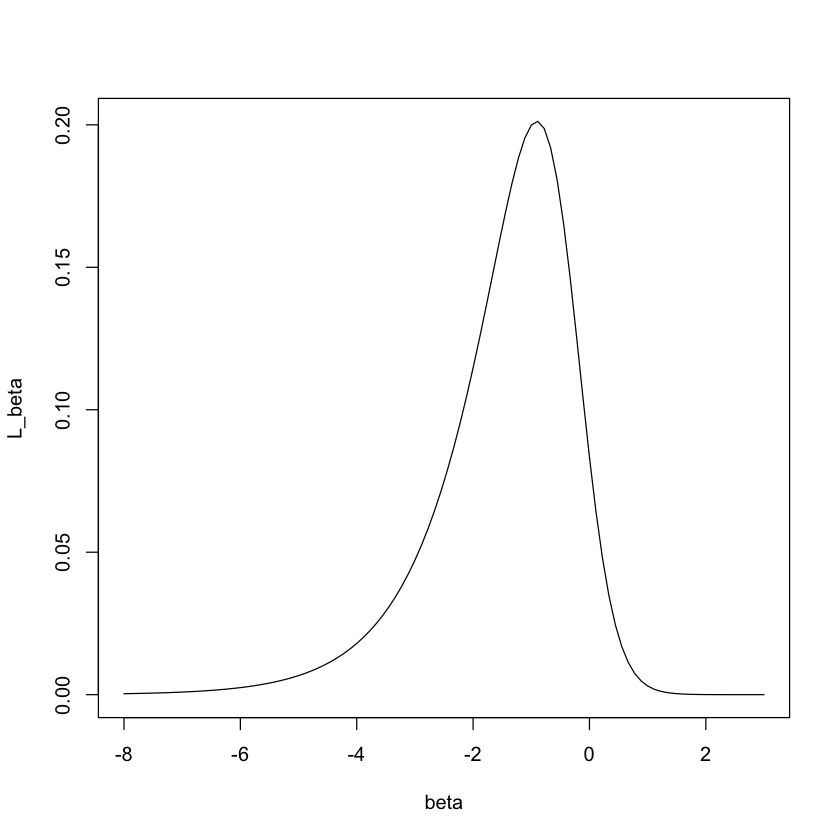

In [3]:
L = function(beta) {
    return(
        (exp(4*beta) / (exp(4*beta)+exp(3*beta)+exp(5*beta)+exp(6*beta)))*
        (exp(3*beta) / (exp(3*beta)+exp(5*beta)+exp(6*beta)))
    )
}

beta = seq(from = -8, to = 3, length.out = 100)
L_beta = L(beta)

par(bg="white")
plot(beta, L_beta, type="l")

This does indeed look concave.

**(2) In R, find $\hat{\beta}$ that maximize this log partial likelihood function, calculate the second derivative of the log partial likelihood function at $\hat{\beta}$.**

In [4]:
# Find index of maximum value in L_beta
max_idx = which.max(L_beta)

# Get corresponding beta value
beta_max = beta[max_idx]

print(paste("Approximate beta that maximizes likelihood:", round(beta_max, 4)))

[1] "Approximate beta that maximizes likelihood: -0.8889"


This just picks the best beta among the 100 options we gave it. So, it's probably closeish, but not exactly right.

In [5]:
optim(par = 0, fn = \(x) -L(x), lower = -8, upper = 3)

Warning message in optim(par = 0, fn = function(x) -L(x), lower = -8, upper = 3):
“bounds can only be used with method L-BFGS-B (or Brent)”


$par
[1] -0.9029857

$value
[1] -0.2012569

$counts
function gradient 
       9        9 

$convergence
[1] 0

$message
[1] "CONVERGENCE: REL_REDUCTION_OF_F <= FACTR*EPSMCH"

So, we get an answer of -0.902985665905265. This seems right looking at the graph.

Symbolic answer

In [6]:
b_hat = -0.902985665905265

L_sym = expression(
    log((exp(4*beta) / (exp(4*beta)+exp(3*beta)+exp(5*beta)+exp(6*beta)))) +
    log(exp(3*beta) / (exp(3*beta)+exp(5*beta)+exp(6*beta)))
)

# dd_L_sym = D(D())
dL = D(L_sym, "beta")
d2L = D(dL, "beta")

fi = -eval(d2L, list(beta=b_hat))
fi

[1] 1.526725

In [7]:
hazard_ratio = exp(b_hat)
hazard_ratio

[1] 0.4053576

In [8]:
confidence_interval = c(exp(b_hat - 1.96*sqrt(1/fi)), exp(b_hat + 1.96*sqrt(1/fi)))
confidence_interval

[1] 0.08297216 1.98036043

So, the estimated hazard ratio is 0.406, and the 95% CI is (0.08287, 1.98).

**(3) (Optional if you have SAS) Use Phreg in SAS (sample code from `Cox model rationale' in Week 10 folder) to fit the above proportional hazards model to the data. How do your results compare to those from the SAS output?**

No SAS

**(4) Redo (d) using coxph in R. What is the estimated hazard ratio (i.e., $exp(\hat{\beta}))$ and its 95\%CI?**

In [9]:
surv = Surv(data$time, data$observed)
m = coxph(surv ~ z, data = data)
summary(m)

Call:
coxph(formula = surv ~ z, data = data)

  n= 4, number of events= 3 

     coef exp(coef) se(coef)      z Pr(>|z|)
z -0.9030    0.4054   0.8093 -1.116    0.265

  exp(coef) exp(-coef) lower .95 upper .95
z    0.4054      2.467   0.08297      1.98

Concordance= 0.8  (se = 0.16 )
Likelihood ratio test= 1.76  on 1 df,   p=0.2
Wald test            = 1.24  on 1 df,   p=0.3
Score (logrank) test = 1.67  on 1 df,   p=0.2


The estimated hazard ratio is 0.406, and the 95% CI is (0.08287, 1.98). This is the same as the results we got earlier.

**(5) Redo (e) using R code assuming a Weibull model (it is also a proportional hazards model). What is the estimated hazard ratio (i.e., $exp(\hat{\beta}))$ and its 95\%CI?**

In [10]:
w = WeibullReg(surv ~ z, data = data)
w

$formula
surv ~ z

$coef
            Estimate           SE
lambda  8.925114e-14 1.471297e-12
gamma   1.662897e+01 8.821129e+00
z      -1.390989e+00 7.719864e-01

$HR
         HR        LB       UB
z 0.2488292 0.0548006 1.129841

$ETR
       ETR       LB       UB
z 1.087247 1.031792 1.145681

$summary

Call:
survival::survreg(formula = formula, data = data, dist = "weibull")
              Value Std. Error     z       p
(Intercept)  1.8069     0.1208 14.95 < 2e-16
z            0.0836     0.0267  3.13  0.0017
Log(scale)  -2.8111     0.5305 -5.30 1.2e-07

Scale= 0.0601 

Weibull distribution
Loglik(model)= -3.9   Loglik(intercept only)= -5.9
	Chisq= 4.1 on 1 degrees of freedom, p= 0.043 
Number of Newton-Raphson Iterations: 8 
n= 4 



So, the hazard ratio is estimated at 0.2488292 and the 95% CI is (0.0548006, 1.129841).

**(6) What is your interpretation about the hazard ratio $exp(\hat{\beta})$? Is the covariate $z$ a continuous variable or a categorical variable?**

The hazard ratio in this context is the ratio between the hazard functions of two units which differ by one unit of $z$. In this problem, we are treating $z$ as a number, so it's cardinal. It might be continuous or discrete, but it's not a categorical variable.